## Basic Operations

This notebook showcases a list of `basic operations and calculations` that you can perform on an xarray dataset storing satellite data:

***
1. Band Arithmetic
2. Spectral Indices Calculation
3. Temporal Analysis
4. Cloud Masking
5. Exporting Data

***

### Load Required Libraries

In [36]:
import pyproj
import pystac_client

from shapely.geometry import box
from shapely.ops import transform

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import odc.stac
from odc.geo.geobox import GeoBox

from datacube.utils.cog import write_cog

In [37]:
def calculate_index(data, index):

    """
    Optical Indices Computation

    :param xarray: datacube_object
    :param string: you want to compute
    
    """
    if index.lower() == 'cri2':
        B02 = data.B02.astype('float16')
        B05 = data.B05.astype('float16')
        return (1/B02)-(1/B05)
    if index.lower() == 'ndvi':
        B08 = data.B08.astype('float16')
        B04 = data.B04.astype('float16')
        return (B08-B04)/(B08+B04)
    if index.lower() == 'ndwi':
        B08 = data.B08.astype('float16')
        B03 = data.B03.astype('float16')
        return (B03-B08)/(B08+B03)
    if index.lower() == 'ndmi':
        B08 = data.B08.astype('float16')
        B11 = data.B11.astype('float16')
        return (B08-B11)/(B08+B11)
    if index.lower() == 'psri':
        B02 = data.B02.astype('float16')
        B04 = data.B04.astype('float16')
        B06 = data.B06.astype('float16')
        return (B04-B02)/ B06
    if index.lower() == 'savi':
        L = 0.428
        B08 = data.B08.astype('float16')
        B04 = data.B04.astype('float16')
        return ((B08 - B04)/(B08 + B04 + L))*(1.0 + L)
    if index.lower() == 'evi':
        B08 = data.B08.astype('float16')
        B04 = data.B04.astype('float16')
        return 2.5*(B08-B04)/((B08+6*B04-7.5*B02) + 1.0)
    if index.lower() == 'nbr':
        B12 = data.B12.astype('float16')
        B08 = data.B08.astype('float16')
        return (B08-B12)/(B08+B12)

In [38]:
def digitize_date(month,day):    
    if month<10:
        month=f"0{month}"

    if day<10:
        day=f"0{day}"

    return month,day

STAC_URL = "https://earth-search.aws.element84.com/v0"
# STAC connection information for Sentinel 2 COGs
# v0 collection
STAC_COLLECTION = "sentinel-s2-l2a-cogs"
# v1 collection 
# STAC_COLLECTION = "sentinel-2-l2a"


# spatial projection information
CRS_STRING = "9705"
EPSG = pyproj.CRS.from_string(CRS_STRING).to_epsg()

aoi = (23.906250,38.000356,24.004786,38.062149)
aoi_box = box(*aoi)

BANDS = ["B04", "B03", "B02", "B05","B06","B08","B11","B12","SCL"]
# BANDS = ["red", "green", "blue"]
START_DATE = "2022-06-01"
END_DATE = "2022-08-31"

# STAC items store bounding box info in epsg:4326
transformer_4326 = pyproj.Transformer.from_crs(
    crs_from=CRS_STRING,
    crs_to="epsg:4326",
    always_xy=True,
)
bbox_4326 = transform(transformer_4326.transform, aoi_box).bounds

catalog = pystac_client.Client.open(STAC_URL)
catalog.add_conforms_to("ITEM_SEARCH")
catalog.add_conforms_to("QUERY")

stac_items = catalog.search(
    collections=[STAC_COLLECTION],
    bbox=bbox_4326,
    datetime=[START_DATE, END_DATE],
    query={"eo:cloud_cover": {"lt": 10}}
)

# dx = 3/3600  # ~90m resolution
dx = 20 / 111320 # ~20m res
epsg = 4326
geobox = GeoBox.from_bbox(aoi, crs=f"epsg:{epsg}", resolution=dx)

# using Open Data Cube stac component
data = odc.stac.load(
    stac_items.items(),
    chunks={},
    geobox=geobox,
    bands=BANDS,
    resampling="bilinear",
    groupby="solar_day" # delete duplicates due to satellite overlap
)

In [39]:
data

<xarray.Dataset> Size: 95MB
Dimensions:      (latitude: 345, longitude: 549, time: 14)
Coordinates:
  * latitude     (latitude) float64 3kB 38.06 38.06 38.06 ... 38.0 38.0 38.0
  * longitude    (longitude) float64 4kB 23.91 23.91 23.91 ... 24.0 24.0 24.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 112B 2022-06-04T09:19:50 ... 2022-08-2...
Data variables:
    B04          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B03          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B02          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B05          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B06          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B08          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B11          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B12          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    SCL          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>

### Arithmetic Operations

Perform arithmetic operations (e.g., addition, subtraction, multiplication, division) between bands to derive new spectral indices or composite images.


#### Example: Normalization

Normalization scales all bands to a common range (0 to 1), ensuring that variations in absolute pixel values do not skew comparative analysis. This consistency is essential when comparing spectral indices or conducting multi-temporal analysis.

$$
\begin{aligned}
\text{normalized\_band} & = \frac{(\text{band} - \text{min(band)})}{(\text{max(band)} + \text{min(band)})} \\
\end{aligned}
$$


In [40]:
min_nir = data.B08.min()
max_nir = data.B08.max()
norm_nir = (data.B08 - min_nir) / (max_nir - min_nir) 
norm_nir

<xarray.DataArray 'B08' (time: 14, latitude: 345, longitude: 549)> Size: 11MB
dask.array<truediv, shape=(14, 345, 549), dtype=float32, chunksize=(1, 345, 549), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 3kB 38.06 38.06 38.06 ... 38.0 38.0 38.0
  * longitude    (longitude) float64 4kB 23.91 23.91 23.91 ... 24.0 24.0 24.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 112B 2022-06-04T09:19:50 ... 2022-08-2...

In [41]:
data['B08_norm'] = norm_nir
data

<xarray.Dataset> Size: 106MB
Dimensions:      (latitude: 345, longitude: 549, time: 14)
Coordinates:
  * latitude     (latitude) float64 3kB 38.06 38.06 38.06 ... 38.0 38.0 38.0
  * longitude    (longitude) float64 4kB 23.91 23.91 23.91 ... 24.0 24.0 24.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 112B 2022-06-04T09:19:50 ... 2022-08-2...
Data variables:
    B04          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B03          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B02          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B05          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B06          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B08          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B11          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B12          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    SCL          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B08_norm     (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>

### Spectral Indices Calculation

Spectral indices are indispensable in remote sensing and satellite imagery analysis due to their ability to enhance feature discrimination, quantify biophysical parameters, and monitor environmental changes effectively. By leveraging the distinct reflectance properties of different wavelengths of light, indices like NDVI and EVI provide quantitative measures of vegetation health, canopy structure, and land cover dynamics. This capability supports informed decision-making in agriculture, forestry, and conservation by simplifying complex satellite data into actionable insights. Spectral indices also facilitate the integration of satellite data with predictive models and decision support systems, enabling the monitoring of ecosystem health, resilience to climate change, and responses to natural disasters. Standardized and comparable across different regions and time periods, these indices play a critical role in global environmental assessments and sustainable resource management efforts.

#### NDVI Calculation

In [42]:
data['ndvi'] = (data.B08-data.B04) / (data.B08+data.B04)
data

<xarray.Dataset> Size: 117MB
Dimensions:      (latitude: 345, longitude: 549, time: 14)
Coordinates:
  * latitude     (latitude) float64 3kB 38.06 38.06 38.06 ... 38.0 38.0 38.0
  * longitude    (longitude) float64 4kB 23.91 23.91 23.91 ... 24.0 24.0 24.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 112B 2022-06-04T09:19:50 ... 2022-08-2...
Data variables:
    B04          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B03          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B02          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B05          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B06          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B08          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B11          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B12          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    SCL          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B08_norm     (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    ndvi         (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>

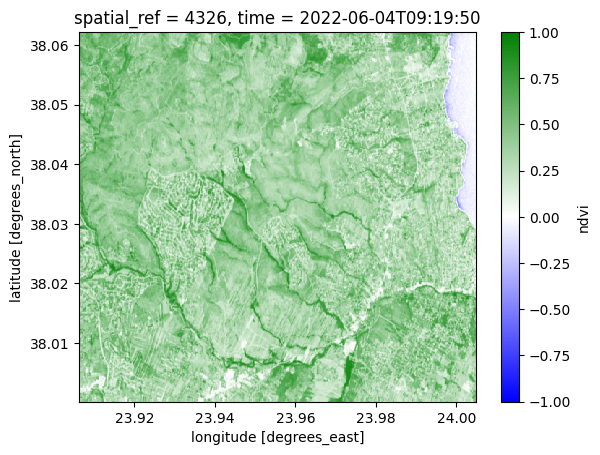

In [43]:
# Remember that the normalised NDVI index is +1 for vegetation, 0 for no vegetation and -1 for water.
# Like so, we create a custom color for properly visualizing the index.
cmap = mcolors.LinearSegmentedColormap.from_list('blue_green', [(0, 'blue'), (0.5, 'white'), (1, 'green')])

# And we plot it
data.ndvi.isel(time=0).plot(vmin=-1,vmax=1,cmap=cmap)

### Temporal Analysis

Temporal analysis in remote sensing refers to the examination of changes in Earth's surface features over time using satellite imagery. An example of temporal analysis using the Normalized Difference Vegetation Index (NDVI) involves plotting NDVI values over multiple time steps to monitor vegetation dynamics. 

In [44]:
data

<xarray.Dataset> Size: 117MB
Dimensions:      (latitude: 345, longitude: 549, time: 14)
Coordinates:
  * latitude     (latitude) float64 3kB 38.06 38.06 38.06 ... 38.0 38.0 38.0
  * longitude    (longitude) float64 4kB 23.91 23.91 23.91 ... 24.0 24.0 24.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 112B 2022-06-04T09:19:50 ... 2022-08-2...
Data variables:
    B04          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B03          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B02          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B05          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B06          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B08          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B11          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B12          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    SCL          (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    B08_norm     (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>
    ndvi         (time, latitude, longitude) float32 11MB dask.array<chunksize=(1, 345, 549), meta=np.ndarray>

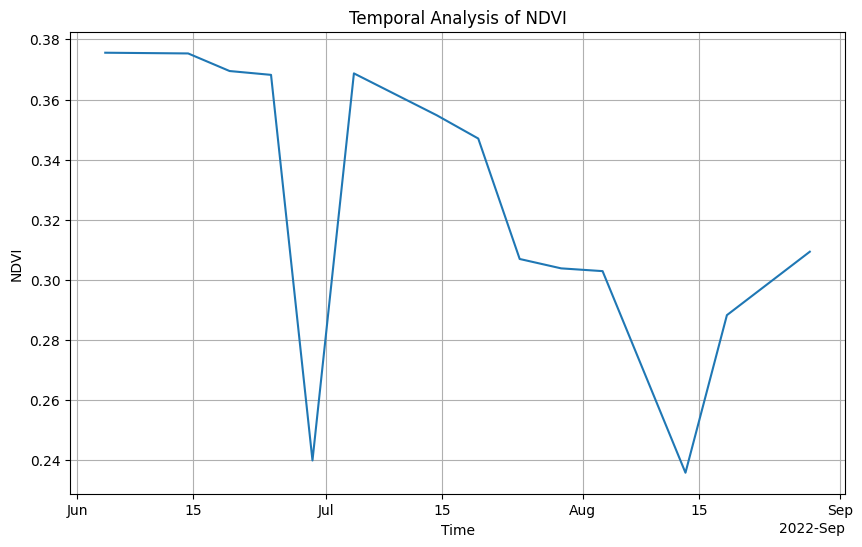

In [45]:
# Plot NDVI time series
plt.figure(figsize=(10, 6))
data.ndvi.mean(dim=['longitude', 'latitude']).plot()  # Plot the mean NDVI across all pixels
plt.title('Temporal Analysis of NDVI')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.grid(True)
plt.show()

**Why is there this sudden drop just before July?** Let's visualise the actual images to check if something is wrong.

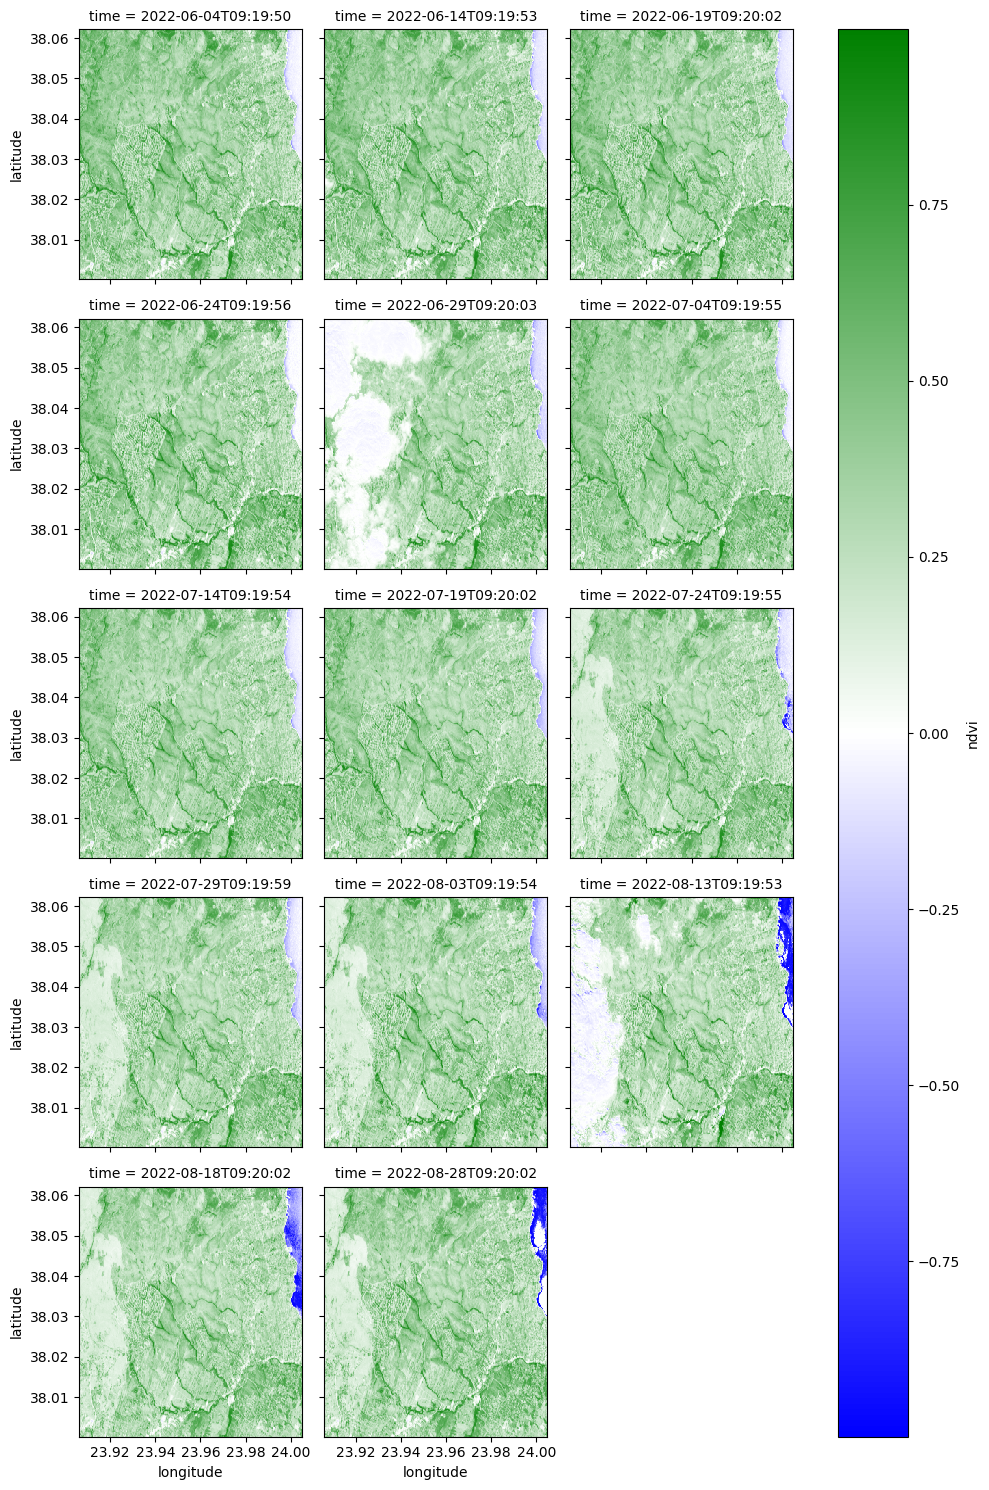

In [46]:
data.ndvi.plot(col='time',col_wrap=3, cmap=cmap)

It's clouds. And that leads us to:

### Cloud Masking

Cloud masking is a critical preprocessing step in satellite image analysis, particularly with Sentinel-2 data, where the Scene Classification Layer (SCL) provides valuable information about pixel quality and atmospheric conditions. The SCL band categorizes each pixel into different classes, including clouds, shadows, vegetation, water, and more. Filtering out cloudy and shadowed pixels from analysis ensures that subsequent operations, such as calculating spectral indices or land cover classification, are based on reliable data. This process improves the accuracy and reliability of remote sensing applications, such as agriculture monitoring, land use mapping, and environmental assessment.

0. Saturated or Defective Pixel
1. Dark Area Pixels
2. Cloud Shadows
3. Vegetation
4. Not-vegetated
5. Water
6. Cloud Medium Probability
7. Cloud High Probability
8. Thin Cirrus
9. Snow or Ice
10. Cloud Shadows (non-vegetated)
11. Thin Cirrus (non-vegetated)

#### Example: Filtering Clouds Using Sentinel-2 SCL Band

In the following example we will keep only pixels that are classified as 3,4 and 5

In [47]:
# Define values indicating clouds and shadows in SCL band
cloud_mask = (data.SCL == 3) | (data.SCL == 4) | (data.SCL == 5)

# Apply cloud mask to the original dataset
data_masked = data.where(cloud_mask)

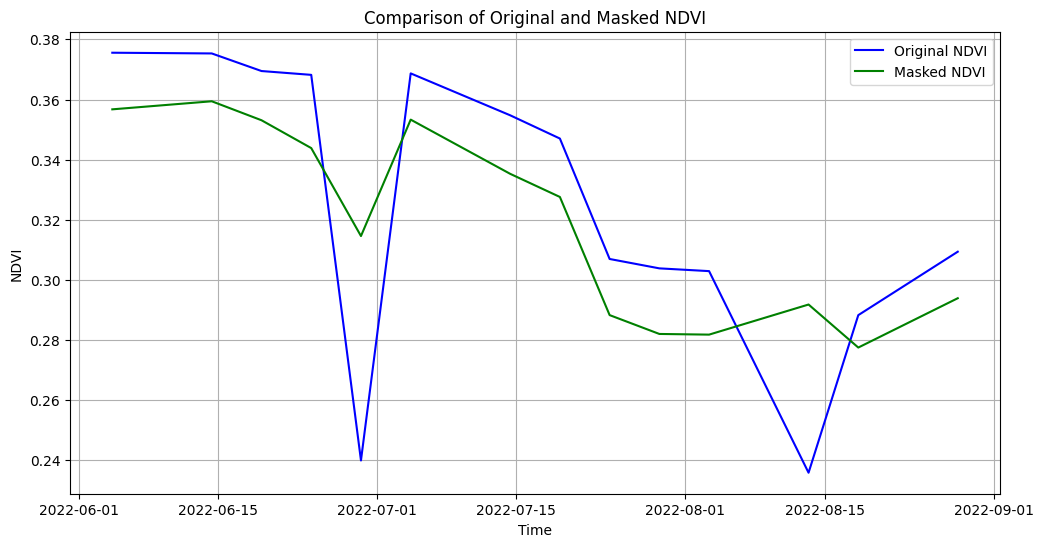

In [48]:
# Plot both NDVI datasets in the same plot
plt.figure(figsize=(12, 6))
plt.plot(data.time, data.ndvi.mean(dim=['longitude', 'latitude']), label='Original NDVI', color='blue')
plt.plot(data_masked.time, data_masked.ndvi.mean(dim=['longitude', 'latitude']), label='Masked NDVI', color='green')
plt.title('Comparison of Original and Masked NDVI')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.legend()
plt.grid(True)
plt.show()

### Export Image

Export processed data, visualizations, or derived indices to formats suitable for further analysis or integration with GIS software.

In [53]:
# Write the predicted data out to a GeoTIFF
write_cog(data.ndvi.isel(time=0),'./ndvi_baseline.tif',overwrite=True).compute()

PosixPath('ndvi_baseline.tif')

In [54]:
!ls

02_Load_Data_Using_STAC.ipynb  04_Basic_RS_Operations.ipynb  ndvi_baseline.tif
03_Visualization.ipynb	       05_A_Real_Life_Example.ipynb
